In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm


In [2]:
# Data loading and transformation

#TODO transforms.Normalize((0.5,), (0.5,)
transform = transforms.Compose([transforms.ToTensor()])
#TODO
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17846264.73it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 516242.11it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3786160.37it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7113715.00it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
# Define Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(128 * 4 * 4, 12)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [19]:
# Combine Encoder and Decoder into an Autoencoder (same as above)
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)

        x = self.decoder(x)
        return x


In [9]:
# Define Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(12, 128 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding = 1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding = 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2,output_padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 128, 4, 4)
        x = F.relu(self.deconv1(x))  # Output shape: (batch_size, 64, 8, 8)
        x = self.deconv2(x)  # Output shape: (batch_size, 32, 16, 16)
        x = F.relu(self.bn1(x))
        x = torch.sigmoid(self.deconv3(x))  # Output shape: (batch_size, 1, 28, 28)

        return x


In [20]:
# Model, Loss, Optimizer (same as above)
autoencoder = Autoencoder()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [21]:
 # Move model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
autoencoder.to(device)


Autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc): Linear(in_features=2048, out_features=12, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=12, out_features=2048, bias=True)
    (deconv1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (deconv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (deconv3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
  )
)

In [22]:
num_epochs = 20

# Lists to store losses
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    autoencoder.train()
    running_loss = 0.0

    for data, _ in tqdm(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        output = autoencoder(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Evaluation
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            output = autoencoder(data)
            val_loss += criterion(output, data).item()

    test_losses.append(val_loss / len(test_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_losses[-1]:.4f}, Validation Loss: {test_losses[-1]:.4f}')



100%|██████████| 938/938 [00:10<00:00, 85.89it/s]


Epoch [1/20], Training Loss: 0.1023, Validation Loss: 0.0696


100%|██████████| 938/938 [00:11<00:00, 85.21it/s]


Epoch [2/20], Training Loss: 0.0627, Validation Loss: 0.0553


100%|██████████| 938/938 [00:11<00:00, 85.24it/s]


Epoch [3/20], Training Loss: 0.0507, Validation Loss: 0.0457


100%|██████████| 938/938 [00:10<00:00, 85.72it/s]


Epoch [4/20], Training Loss: 0.0428, Validation Loss: 0.0407


100%|██████████| 938/938 [00:10<00:00, 85.79it/s]


Epoch [5/20], Training Loss: 0.0380, Validation Loss: 0.0361


100%|██████████| 938/938 [00:11<00:00, 85.24it/s]


Epoch [6/20], Training Loss: 0.0350, Validation Loss: 0.0339


100%|██████████| 938/938 [00:10<00:00, 85.89it/s]


Epoch [7/20], Training Loss: 0.0332, Validation Loss: 0.0323


100%|██████████| 938/938 [00:11<00:00, 84.77it/s]


Epoch [8/20], Training Loss: 0.0319, Validation Loss: 0.0314


100%|██████████| 938/938 [00:11<00:00, 85.16it/s]


Epoch [9/20], Training Loss: 0.0309, Validation Loss: 0.0306


100%|██████████| 938/938 [00:10<00:00, 86.24it/s]


Epoch [10/20], Training Loss: 0.0303, Validation Loss: 0.0303


100%|██████████| 938/938 [00:10<00:00, 85.98it/s]


Epoch [11/20], Training Loss: 0.0298, Validation Loss: 0.0300


100%|██████████| 938/938 [00:10<00:00, 85.97it/s]


Epoch [12/20], Training Loss: 0.0294, Validation Loss: 0.0295


100%|██████████| 938/938 [00:10<00:00, 85.99it/s]


Epoch [13/20], Training Loss: 0.0291, Validation Loss: 0.0293


100%|██████████| 938/938 [00:10<00:00, 86.21it/s]


Epoch [14/20], Training Loss: 0.0288, Validation Loss: 0.0289


100%|██████████| 938/938 [00:11<00:00, 85.27it/s]


Epoch [15/20], Training Loss: 0.0286, Validation Loss: 0.0288


100%|██████████| 938/938 [00:10<00:00, 86.07it/s]


Epoch [16/20], Training Loss: 0.0284, Validation Loss: 0.0288


100%|██████████| 938/938 [00:10<00:00, 85.66it/s]


Epoch [17/20], Training Loss: 0.0283, Validation Loss: 0.0285


100%|██████████| 938/938 [00:10<00:00, 85.92it/s]


Epoch [18/20], Training Loss: 0.0281, Validation Loss: 0.0287


100%|██████████| 938/938 [00:10<00:00, 85.77it/s]


Epoch [19/20], Training Loss: 0.0280, Validation Loss: 0.0283


100%|██████████| 938/938 [00:11<00:00, 85.13it/s]


Epoch [20/20], Training Loss: 0.0279, Validation Loss: 0.0282


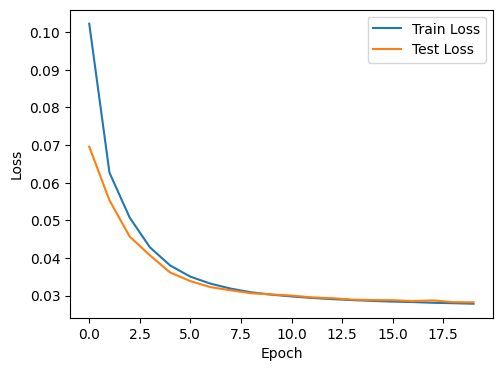

In [24]:
# Plotting training and test losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

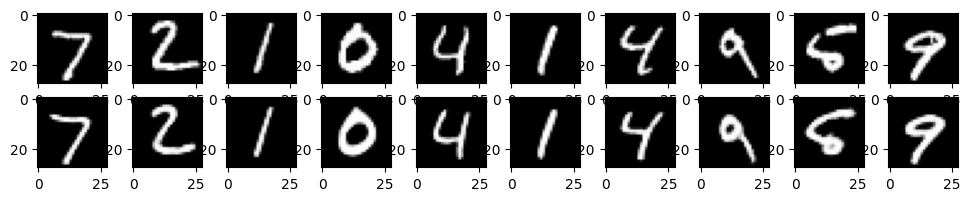

In [25]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Assuming `autoencoder` is already defined and moved to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get a batch of test data
_, (images, _) = next(enumerate(test_loader))   # Directly fetch the next batch

# Move images to GPU if available
images = images.to(device)

# Generate output from the autoencoder
with torch.no_grad():
    output = autoencoder(images)

# Move output back to CPU if necessary for plotting
output = output.cpu()

# Plot input and output images
fig, axes = plt.subplots(2, 10, figsize=(12, 2))
for i in range(10):
    axes[0, i].imshow(images[i].squeeze().cpu().numpy(), cmap='gray')
    axes[1, i].imshow(output[i].squeeze().numpy(), cmap='gray')

plt.show()
